In [2]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=64,
    shuffle=True
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.12MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(-1, 28*28))


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)


In [8]:
# for epoch in range(3):
#     for i, (imgs, _) in enumerate(dataloader):
#         real_imgs = imgs.to(device)
#         b_size = real_imgs.size(0)

#         real_labels = torch.ones(b_size, 1).to(device)
#         fake_labels = torch.zeros(b_size, 1).to(device)

#         # Generator training
#         z = torch.randn(b_size, 100).to(device)
#         fake_imgs = G(z)
#         g_loss = criterion(D(fake_imgs), real_labels)

#         optimizer_G.zero_grad()
#         g_loss.backward()
#         optimizer_G.step()

#         # Discriminator training
#         d_real_loss = criterion(D(real_imgs), real_labels)
#         d_fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
#         d_loss = d_real_loss + d_fake_loss

#         optimizer_D.zero_grad()
#         d_loss.backward()
#         optimizer_D.step()

#     print(f"Epoch [{epoch+1}/3] | Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")
import torchvision.utils as vutils
import os
import numpy as np

# Create output folder once
if not os.path.exists("gan_outputs"):
    os.makedirs("gan_outputs")

for epoch in range(15):  # Changed from 3 to 15
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        b_size = real_imgs.size(0)

        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)

        # Generator training
        z = torch.randn(b_size, 100).to(device)
        fake_imgs = G(z)
        g_loss = criterion(D(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Discriminator training
        d_real_loss = criterion(D(real_imgs), real_labels)
        d_fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        d_loss = d_real_loss + d_fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/15] | Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

    # ✅ Add this block below print (end of each epoch)
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            test_noise = torch.randn(64, 100).to(device)
            generated = G(test_noise).detach().cpu()
            grid = vutils.make_grid(generated, padding=2, normalize=True)

            plt.figure(figsize=(6,6))
            plt.axis("off")
            plt.title(f"Generated at Epoch {epoch+1}")
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.savefig(f"gan_outputs/epoch_{epoch+1}.png")
            plt.close()



Epoch [1/15] | Generator Loss: 4.8477, Discriminator Loss: 0.3902
Epoch [2/15] | Generator Loss: 2.2215, Discriminator Loss: 0.2873
Epoch [3/15] | Generator Loss: 8.1752, Discriminator Loss: 0.1869
Epoch [4/15] | Generator Loss: 4.3628, Discriminator Loss: 0.6041
Epoch [5/15] | Generator Loss: 6.7891, Discriminator Loss: 0.0812
Epoch [6/15] | Generator Loss: 4.4374, Discriminator Loss: 0.2407
Epoch [7/15] | Generator Loss: 3.9608, Discriminator Loss: 0.1625
Epoch [8/15] | Generator Loss: 4.3745, Discriminator Loss: 0.1589
Epoch [9/15] | Generator Loss: 4.5904, Discriminator Loss: 0.3137
Epoch [10/15] | Generator Loss: 5.0326, Discriminator Loss: 0.0354
Epoch [11/15] | Generator Loss: 3.6373, Discriminator Loss: 0.3008
Epoch [12/15] | Generator Loss: 5.4939, Discriminator Loss: 0.4053
Epoch [13/15] | Generator Loss: 4.1762, Discriminator Loss: 0.2979
Epoch [14/15] | Generator Loss: 3.3617, Discriminator Loss: 0.4114
Epoch [15/15] | Generator Loss: 3.0489, Discriminator Loss: 0.5508


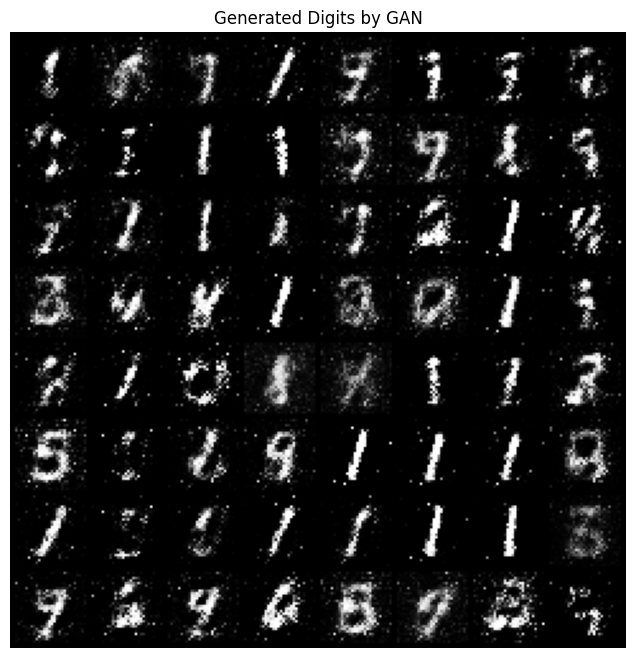

In [9]:
with torch.no_grad():
    z = torch.randn(64, 100).to(device)
    generated = G(z).cpu()
    grid = make_grid(generated, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title("Generated Digits by GAN")
    plt.show()
